# <추론 기반 기법>
- 저번 장에서는 통계 기반 기법을 배움

### 통계 기반 기법의 문제점
- 통계 기반 기법에서는 주변 단어의 빈도를 기초로 단어를 표현함 -> 현업의 말뭉치 수는 엄청나므로 엄청난 크기의 행렬을 만들게 됨 (SVD 적용 힘듦)
- 통계 기반에서는 단 1회의 처리만에 분산 표현을 얻음
- 추론 기반 기법
    - 추론 기반에서는 여러번의 미니배치로 학습함
    - GPU와 함께 학습 속도를 높일 수 있음
    - 맥락을 입력하면 각 단어의 출현을 확률 분포로 출력 

### 신경망에서의 단어 처리
- 원핫 표현

In [1]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) # 입력 1x7
W = np.random.randn(7, 3) # 가중치 7x3
h = np.matmul(c, W) # 중간 노드
print(h)

# c와 W의 행렬 곱의 의미
# id에 대응하는 원소만 1이므로 가중치의 행벡터 하나를 뽑아낸 것과 같음
# 그냥 뽑아내면 되지 뭐하러 행렬 곱을 계산할까? ->  비효율적

[[-0.47338417  0.81069092 -0.33975004]]


In [4]:
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7, 3) 
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.8294234  -0.03991286 -1.32249573]]


# <단순한 Word2Vec>
- CBOW 모델을 사용함

### CBOW 모델의 추론 처리
- 맥락으로부터 타깃을 추측하는 용도의 신경망
- 입력층 N개, 은닉층을 거쳐 출력층에 도달
    - 맥락으로 고려할 단어를 N개로 정했기 때문
- 입력층 -> 은닉층의 가중치 W(in)은 단어의 분산 표현임
    - 학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 분산표현들이 갱신

In [5]:
# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in) # layer0과
in_layer1 = MatMul(W_in) # layer1의 가중치는 같은 것을 공유한다.
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[-0.02748353  0.64250634 -0.10994765  0.69577267 -0.78917221  0.48299712
  -0.243841  ]]


### CBOW 모델의 학습
- Softmax with Loss 계층을 통해 학습함

### Word2Vec의 가중치와 분산 표현
- 단어의 분산 표현으로 입력 가중치와 출력 가중치 둘 중 어떤 가중치를 선택해야할까?
    - 대중적 : 입력 측의 가중치만 이용한다!

### 학습 데이터 준비

In [23]:
from common.util import preprocess
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [24]:
# from common.util import create_context_target

def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [29]:
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size=1)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [32]:
print(contexts)
print(target)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


### CBOW 모델 구현

In [33]:
from common.layers import SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### nn 구현

In [ ]:
# import torch

# class SimpleCBOW(nn.Module):
#     def __init__(self, vocab_size, hidden_size):
#         super().__init__()
        
#         V, H = vocab_size, hidden_size

#         # 가중치 초기화
#         self.W_in = nn.Linear(V, H)
#         self.W_out = nn.Linear(V, H)
#         torch.nn.init.xavier_uniform_(self.W_in.weight)
#         torch.nn.init.xavier_uniform_(self.W_out.weight)

#         # 계층 생성
        
#         # 모든 가중치와 기울기를 리스트에 모으기
        
#         # 인스턴스 변수에 단어의 분산 표현을 저장
#         self.linear = nn.Linear(4,3)
    
#     def forward(self, x):
#         return self.linear(x)
    
    

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/Users/gyuyeonjo/opt/anaconda3/envs/deep_torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyuyeonjo/opt/anaconda3/envs/deep_torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyuyeonjo/opt/anaconda3/envs/deep_torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gyuyeonjo/opt/anaconda3/envs/deep_torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


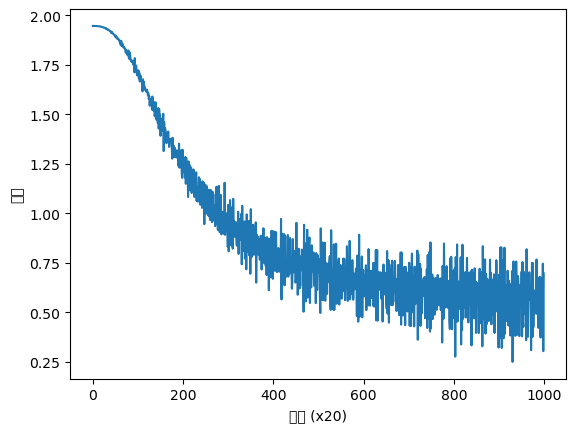

you [ 1.1048025 -1.1086749  1.2791375  1.0834943  1.2287949]
say [-1.2120442   1.2363162  -0.11666328 -1.2259313  -0.23135707]
goodbye [ 0.94142187 -0.8538699   0.58915955  0.89912474  0.63831025]
and [-1.0578206  1.0925983 -1.5953009 -1.0750928 -1.6006361]
i [ 0.91170365 -0.86992323  0.60124433  0.91400486  0.62862676]
hello [ 1.0825422 -1.1248953  1.2678351  1.0737585  1.2412546]
. [-1.033797   1.0398252  1.4067674 -1.0357765  1.4415942]


In [35]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 단어를 밀집벡터로 표현, 이 밀집벡터가 바로 단어의 분산 표현임
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

# <Word2Vec 보충>

### CBOW 모델과 확률

### Skip-Gram 모델

### 통계 기반 vs 추론 기반